# Phase 2 Project

## Overview

A company that buys houses to flip and resell is interested in finding out what pre-existine features of houses are likely to lead to a higher sale price. Since they plan on "flipping" the house, or adding their own renovations, they aren't as interested in details such as the overall condition of the house and are more interested in things such as location, how big of a lot the house is built on, etc.

## Business Understanding

The features of the data from a housing dataset that I will be looking at, and comparing to the sale price of the houses, include number of bedrooms, number of bathrooms, square footage of the living area, square footage of the lot, number of floors, whether the house is on a waterfront, whether the house is adjacent to a green belt, whether the house has traffic noise or other nuisances, and the quality of the view of the house. 
After performing exploratory data analysis and determining which of these factors seem to relate to sale price, I will narrow down my efforts to determine which of those factors are the best predictors of sale price.

## Data Understanding

I begin by importing the necessary modules and the dataset I will be using, which includes housing data for King County.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import numpy as np
import math
import matplotlib.cm as cm
%matplotlib nbagg
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [7]:
data = pd.read_csv('Data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


Next, I try to find out more about the data and narrow down the dataframe I will be using to only include the necessary columns.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

<IPython.core.display.Javascript object>


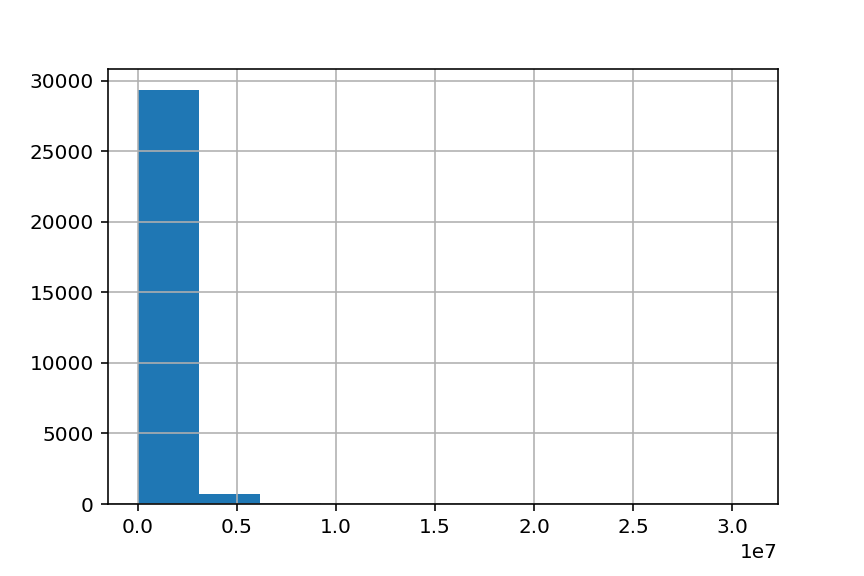

In [9]:
data['price'].hist();

<IPython.core.display.Javascript object>


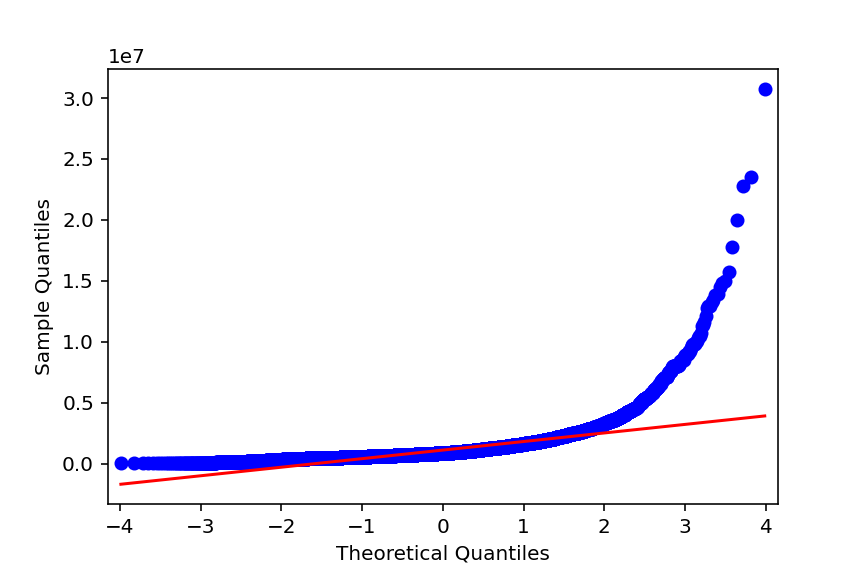

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


In [10]:
price_qq = sm.qqplot(data['price'], line='r');

This QQ plot shows that the quantiles of our target variable, price, do not align with a normal distribution that well.

In [94]:
np.log(data['price']).hist();

The log-transformed version of price looks way more normal than the original variable's distribution.

<IPython.core.display.Javascript object>


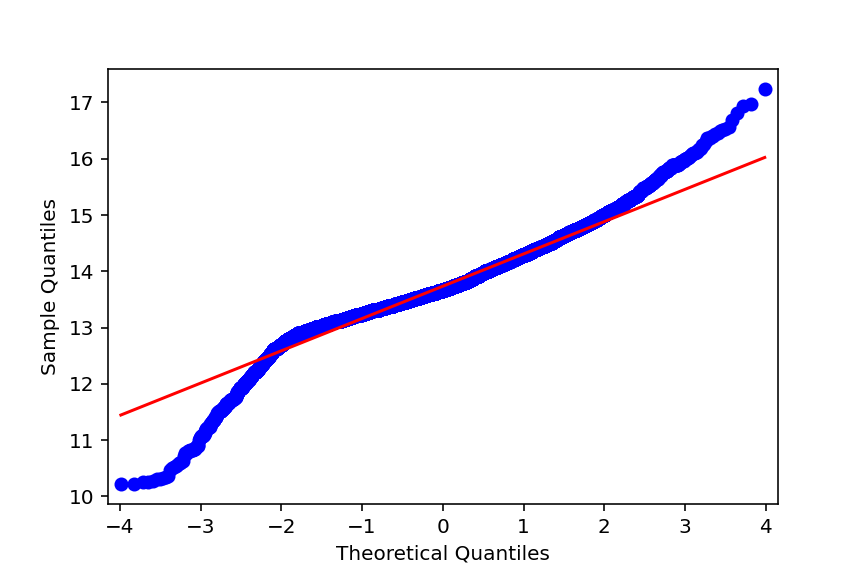

In [73]:
sm.qqplot(np.log(data['price']), line='r');

This QQ plot is still not perfectly linear but is it better than before we log-transformed the target.

## Data Preparation

I want to know which variables are most correlated with price, so that I can choose a feature for the baseline model. However, first I want to make sure there is no multicollinearity that will later affect my results.

In [11]:
data_all = data.copy()

In [12]:
data_pred = data_all.iloc[:,2:21]
data_pred.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built
0,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969
1,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950
2,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956
3,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010
4,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012


In [13]:
data_pred.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built
price,1.000000,0.289204,0.480401,0.608521,0.085730,0.180576,0.538651,0.245058,0.264169,0.313409,0.096013
bedrooms,0.289204,1.000000,0.589273,0.637874,0.003306,0.147592,0.547164,0.238502,0.319441,0.183439,0.146191
bathrooms,0.480401,0.589273,1.000000,0.772677,0.035886,0.404412,0.674924,0.260902,0.457022,0.327551,0.443648
sqft_living,0.608521,0.637874,0.772677,1.000000,0.119563,0.304240,0.883984,0.338460,0.511740,0.396030,0.291694
sqft_lot,0.085730,0.003306,0.035886,0.119563,1.000000,-0.032097,0.129231,0.004111,0.087169,0.155250,0.001750
floors,0.180576,0.147592,0.404412,0.304240,-0.032097,1.000000,0.448281,-0.248093,0.132656,0.125183,0.544646
sqft_above,0.538651,0.547164,0.674924,0.883984,0.129231,0.448281,1.000000,-0.066801,0.560551,0.312117,0.387448
sqft_basement,0.245058,0.238502,0.260902,0.338460,0.004111,-0.248093,-0.066801,1.000000,0.026361,0.210500,-0.230226
sqft_garage,0.264169,0.319441,0.457022,0.511740,0.087169,0.132656,0.560551,0.026361,1.000000,0.216354,0.447560
sqft_patio,0.313409,0.183439,0.327551,0.396030,0.155250,0.125183,0.312117,0.210500,0.216354,1.000000,0.138409


In [14]:
df=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

In [15]:
abs(df) > 0.75

,cc
pairs,
"(price, price)",True
"(sqft_living, sqft_above)",True
"(sqft_living, bathrooms)",True
"(bathrooms, sqft_above)",False
"(bedrooms, sqft_living)",False
"(price, sqft_living)",False
"(bedrooms, bathrooms)",False
"(sqft_garage, sqft_above)",False
"(bedrooms, sqft_above)",False


In [16]:
df[(df.cc>.75) & (df.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.883984
"(sqft_living, bathrooms)",0.772677


The two variables most correlated with eachother are sqft_living and sqft_above. This makes sense, because the square feet of the living area is likely a large portion of the square feet above ground for a house. Because of this and because sqft_living is more correlated with the target variable, price, I am going to exclude the variable sqft_above moving forward.

###### Now, to look at the rest of the features:

In [17]:
data1 = data_all.copy()
data1 = data1[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view', 'heat_source', 'sewer_system']]
data1.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,heat_source,sewer_system
0,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Gas,PUBLIC
1,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Oil,PUBLIC
2,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Gas,PUBLIC
3,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Gas,PUBLIC
4,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Electricity,PUBLIC


In [ ]:
data1.corr()["price"]

Of the relevant numeric variables in the data, it looks like the features most correlated with price are sqft_living, bathrooms, and bedrooms. 

In [18]:
data_num = data1.copy().select_dtypes("number")
data_num.dropna(inplace=True)
data_num

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors
0,675000.0,4,1.0,1180,7140,1.0
1,920000.0,5,2.5,2770,6703,1.0
2,311000.0,6,2.0,2880,6156,1.0
3,775000.0,3,3.0,2160,1400,2.0
4,592500.0,2,2.0,1120,758,2.0
...,...,...,...,...,...,...
30150,1555000.0,5,2.0,1910,4000,1.5
30151,1313000.0,3,2.0,2020,5800,2.0
30152,800000.0,3,2.0,1620,3600,1.0
30153,775000.0,3,2.5,2570,2889,2.0


<IPython.core.display.Javascript object>


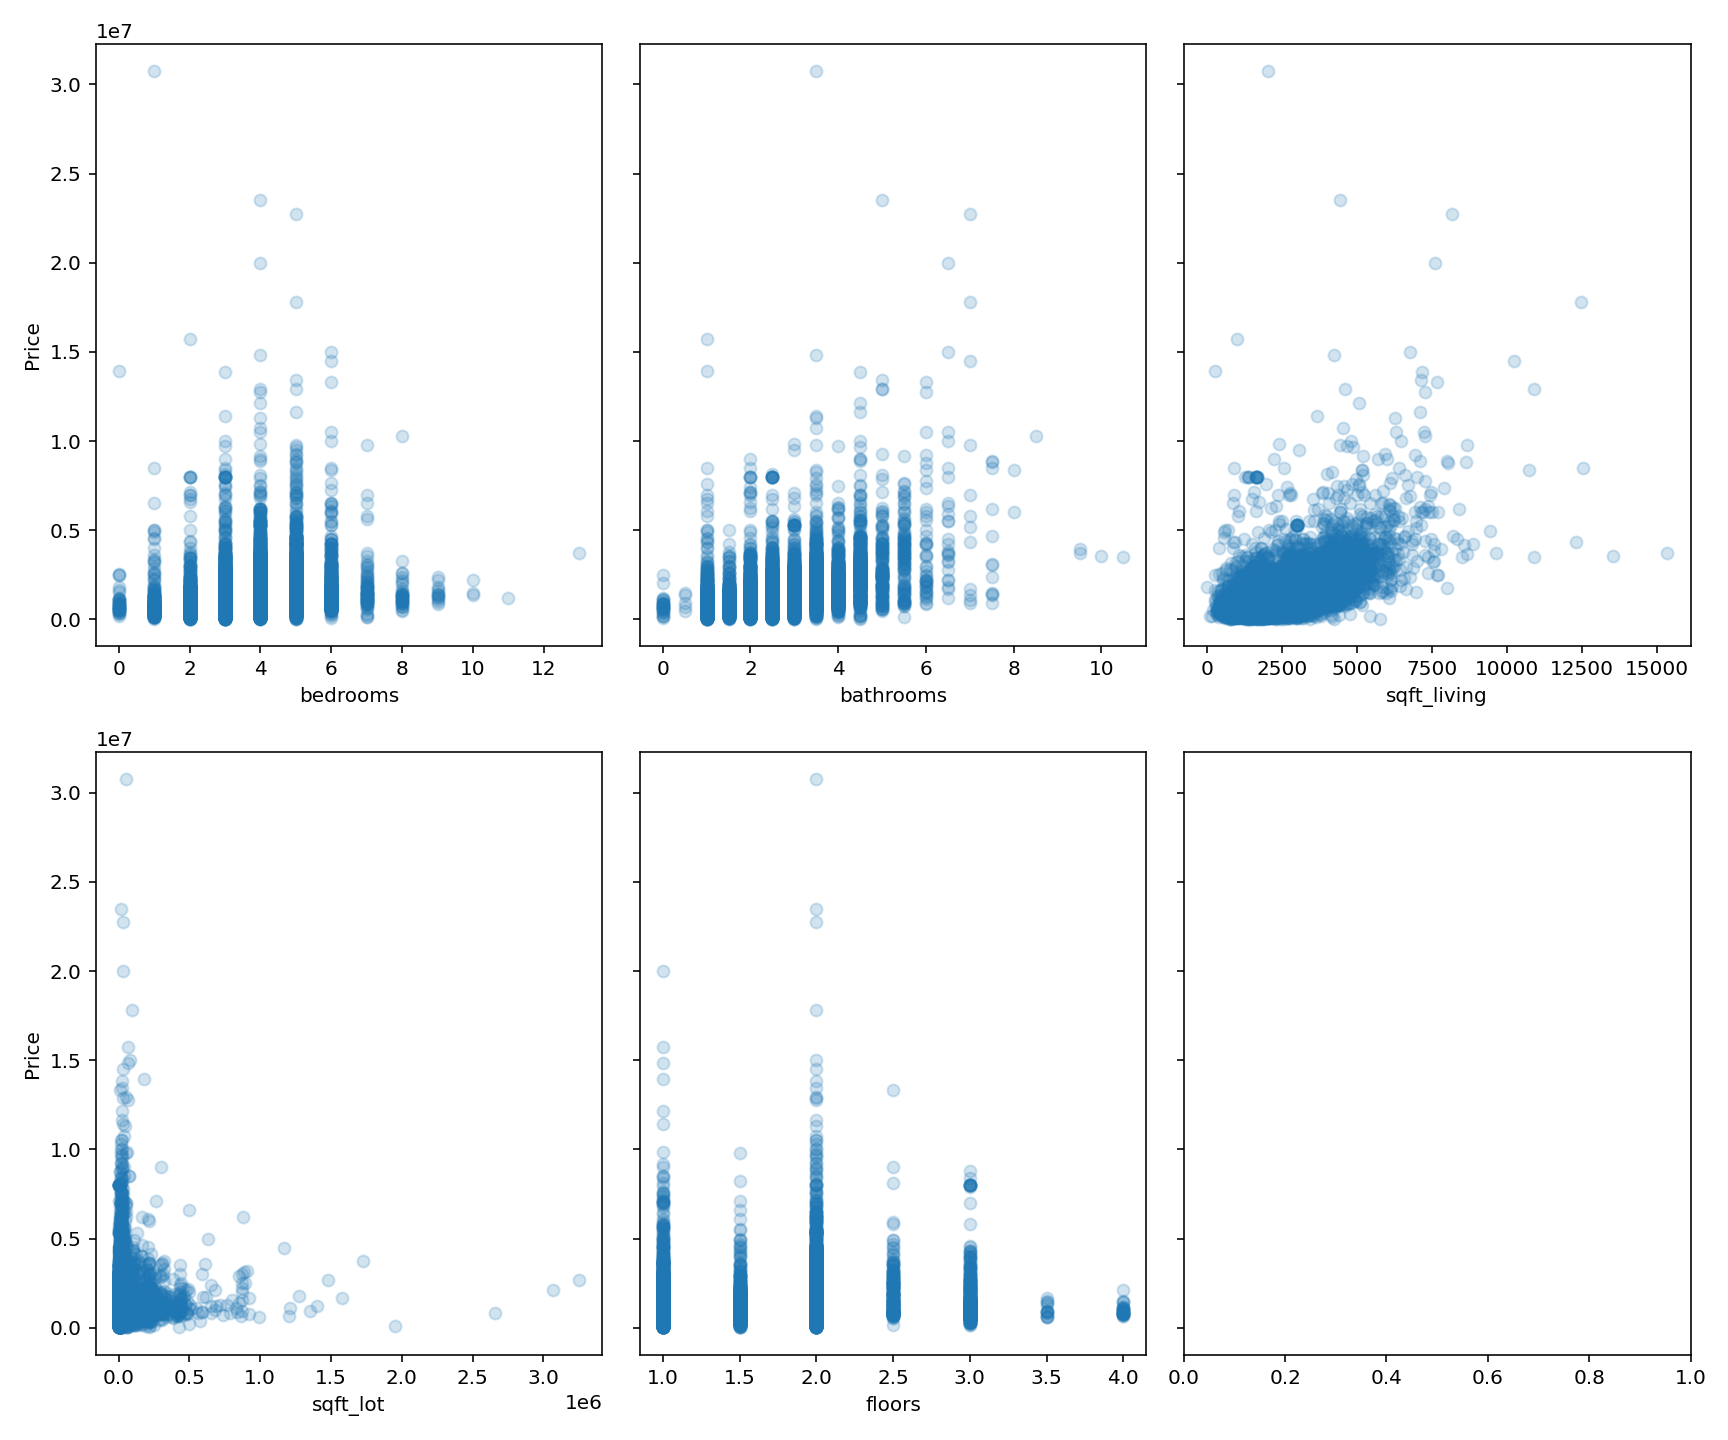

In [157]:
y = data_num["price"]
X = data_num.drop("price", axis=1)


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,10), sharey=True)
#sm.graphics.abline_plot(model_results=baseline_results, label="Regression line", ax=ax)
for i, column in enumerate(X.columns):
    # Locate applicable axes
    row = i // 3
    col = i % 3
    ax = axes[row][col]
    
    # Plot feature vs. y and label axes
    ax.scatter(X[column], y, alpha=0.2)
    ax.set_xlabel(column)
    if col == 0:
        ax.set_ylabel("Price")

fig.tight_layout()

The numeric variable here that appears to have the strongest positive linear relationship with price is sqft_living. As the feature most correlated with price and the one with the strongest linear relationship, sqft_living seems to  be a good variable to build a baseline model with to then compare other variables to.

In [161]:
sqftliving_hist = data_pred['sqft_living'].hist()
plt.show();

<IPython.core.display.Javascript object>


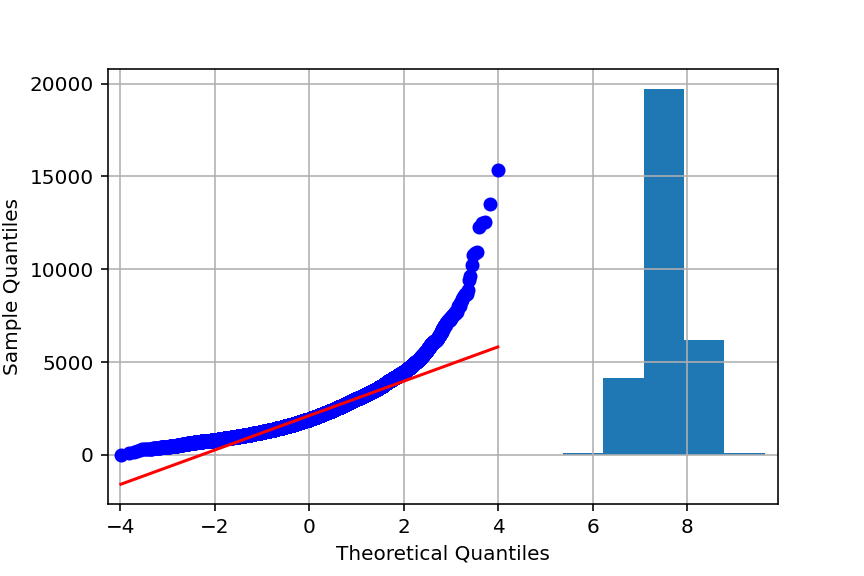

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


In [162]:
sqftliving_qq = sm.qqplot(data_pred['sqft_living'], line='r')
plt.show();

The histogram of sqft_living does not look very normal. To see if it improves the distribution, I am going to try log transforming this variable.

In [163]:
sqftliving_log_hist = np.log(data_pred['sqft_living']).hist()

<IPython.core.display.Javascript object>


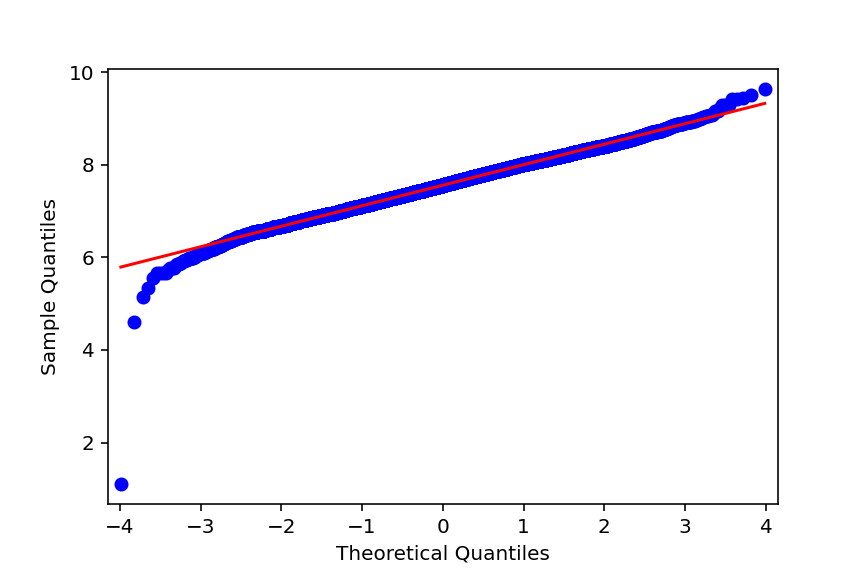

In [164]:
sqftliving_log_qq = sm.qqplot(np.log(data_pred['sqft_living']), line='r');

This looks much more normal than the untransformed variable.

## Modeling

First, a baseline model is created using the variable sqft_living, as it is the most correlated with sale price, to compare all other models to.

In [43]:
y = data1[['price']]
X_baseline = data1[['sqft_living']]

Plotting the actual vs. predicted values of this model:

<IPython.core.display.Javascript object>


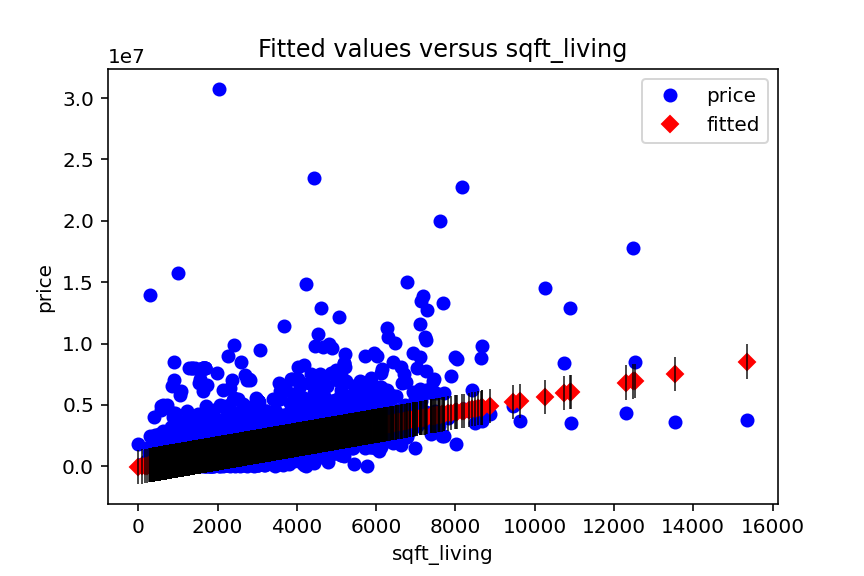

In [44]:
sm.graphics.plot_fit(baseline_results, "sqft_living")
plt.show()

Plotting the regression line:

<IPython.core.display.Javascript object>


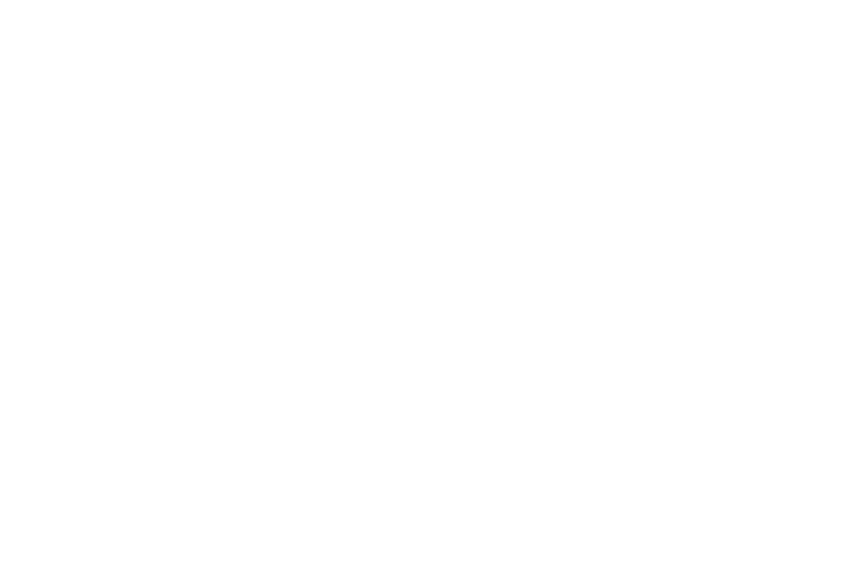

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1010: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


In [95]:
fig, ax = plt.subplots()
data1.plot.scatter(x="sqft_living", y="price", label="Data points", ax=ax)
sm.graphics.abline_plot(model_results=baseline_results, label="Regression line", ax=ax)
ax.legend();

Plotting the residuals:

<IPython.core.display.Javascript object>


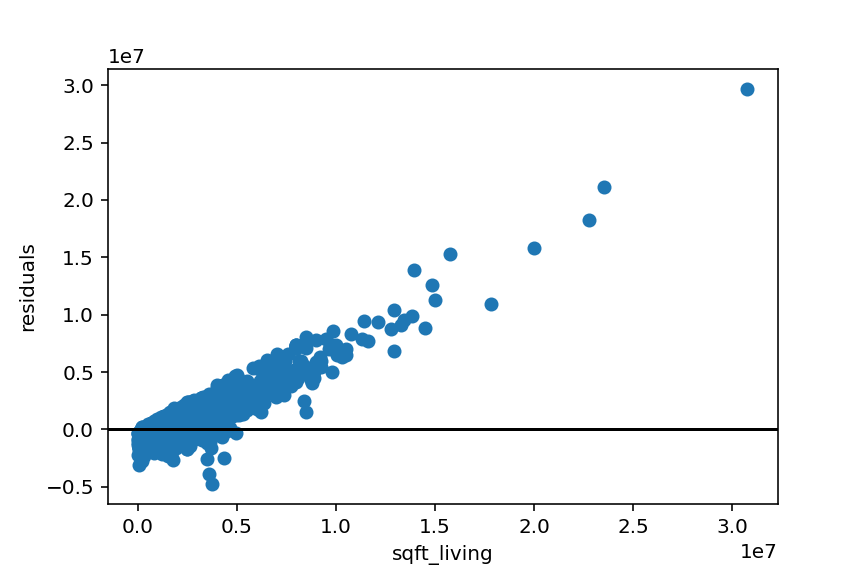

In [101]:
fig, ax = plt.subplots()

ax.scatter(data1["price"], baseline_results.resid)
ax.axhline(y=0, color="black")
ax.set_xlabel("sqft_living")
ax.set_ylabel("residuals");

In [104]:

lr = LinearRegression().fit(X_baseline, y)

In [105]:
preds = lr.predict(X_baseline)

###### Baseline results:

In [35]:
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                 1.773e+04
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        15:25:20   Log-Likelihood:            -4.4912e+05
No. Observations:               30155   AIC:                         8.982e+05
Df Residuals:                   30153   BIC:                         8.983e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.443e+04   9782.728     -7.609      

In [36]:
baseline_results.pvalues

const          2.852024e-14
sqft_living    0.000000e+00
dtype: float64

This baseline model without any tranformed features explains 37% of the variance in sale price of the houses in this dataset and it is statistically significant. Looking at the coefficients, for each increase by 1 square foot in living area, the price is expected to increase by about $560.

In [37]:
y_log = np.log(data['price'])
X_baseline_log = np.log(data_pred['sqft_living'])

In [38]:
baseline_model_Xlog = sm.OLS(y, sm.add_constant(X_baseline_log))
baseline_results_Xlog = baseline_model_Xlog.fit()

print(baseline_results_Xlog.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                 1.086e+04
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        15:25:21   Log-Likelihood:            -4.5146e+05
No. Observations:               30155   AIC:                         9.029e+05
Df Residuals:                   30153   BIC:                         9.029e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.741e+06   7.55e+04    -89.329      

In [39]:
baseline_model_ylog = sm.OLS(y_log, sm.add_constant(X_baseline))
baseline_results_ylog = baseline_model_ylog.fit()

print(baseline_results_ylog.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                 1.898e+04
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        15:25:21   Log-Likelihood:                -19148.
No. Observations:               30155   AIC:                         3.830e+04
Df Residuals:                   30153   BIC:                         3.832e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.9491      0.006   2062.042      

In [45]:
baseline_model_log = sm.OLS(y_log, sm.add_constant(X_baseline_log))
baseline_results_log = baseline_model_log.fit()

print(baseline_results_log.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                 1.612e+04
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        15:26:34   Log-Likelihood:                -20055.
No. Observations:               30155   AIC:                         4.011e+04
Df Residuals:                   30153   BIC:                         4.013e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.8799      0.046    170.559      

In [53]:
baseline_results_log.pvalues

const          0.0
sqft_living    0.0
dtype: float64

Of these models with either a transformed X, a transformed y, or both, the model that seems best is the one with only a log-transformed y.

In [104]:
(baseline_results_ylog.params["sqft_living"])

0.00037196373532233964

In [103]:
np.exp(baseline_results_ylog.params["sqft_living"])

1.0003720329224106

In [105]:
baseline_results_ylog.params["sqft_living"] * 100

0.03719637353223396

Interpretation: for each increase by 1 square foot in living area, we see an associated increase of about 0.04% in price.

#### Numeric data:

Now, to add the other numeric features to a multiple linear regression to see if it improves our model:

In [55]:
X_all = data1.drop(['price'], axis=1).select_dtypes("number")
X_all

,bedrooms,bathrooms,sqft_living,sqft_lot,floors
0,4,1.0,1180,7140,1.0
1,5,2.5,2770,6703,1.0
2,6,2.0,2880,6156,1.0
3,3,3.0,2160,1400,2.0
4,2,2.0,1120,758,2.0
...,...,...,...,...,...
30150,5,2.0,1910,4000,1.5
30151,3,2.0,2020,5800,2.0
30152,3,2.0,1620,3600,1.0
30153,3,2.5,2570,2889,2.0


### Categorical data:

Now, before the categorical variables can be modeled, they will need to be transformed using one-hot encoding.

In [423]:
X_wf = data1[["waterfront"]]
X_gb = data1[["greenbelt"]]
X_nu = data1[["nuisance"]]
X_vw = data1[["view"]]

In [424]:
waterfront_X = pd.get_dummies(X_wf, columns=["waterfront"], drop_first=True)
waterfront_X

,waterfront_YES
0,0
1,0
2,0
3,0
4,0
...,...
30150,0
30151,0
30152,0
30153,0


In [425]:
greenbelt_X = pd.get_dummies(X_gb, columns=["greenbelt"], drop_first=True)
greenbelt_X

,greenbelt_YES
0,0
1,0
2,0
3,0
4,0
...,...
30150,0
30151,0
30152,0
30153,0


In [426]:
nuisance_X = pd.get_dummies(X_nu, columns=["nuisance"], drop_first=True)
nuisance_X

,nuisance_YES
0,0
1,1
2,0
3,0
4,1
...,...
30150,0
30151,0
30152,1
30153,0


In [427]:
X_vw['view'].unique()

array(['NONE', 'AVERAGE', 'EXCELLENT', 'FAIR', 'GOOD'], dtype=object)

In [428]:
view_X = pd.get_dummies(X_vw, columns=["view"], drop_first=True)
view_X

,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
0,0,0,0,1
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,1
...,...,...,...,...
30150,0,0,0,1
30151,0,1,0,0
30152,0,0,0,1
30153,0,0,0,1


### Creating an interaction term ('Excellent' view):

Of the categorical variables, view seems to be the best predictor of price. We will create an interaction term between view and sqft_living to see if the interaction of these two features improve the model.

In [429]:
views_ = data1[['view', 'sqft_living']]

In [430]:
views_X = pd.get_dummies(views_, columns=["view"], drop_first=True)
views_X

,sqft_living,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
0,1180,0,0,0,1
1,2770,0,0,0,0
2,2880,0,0,0,0
3,2160,0,0,0,0
4,1120,0,0,0,1
...,...,...,...,...,...
30150,1910,0,0,0,1
30151,2020,0,1,0,0
30152,1620,0,0,0,1
30153,2570,0,0,0,1


In [431]:
X_interaction = views_X.copy()
X_interaction["sqft_living x Excellent view"] = X_interaction["sqft_living"] * X_interaction["view_EXCELLENT"]
X_interaction

,sqft_living,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,sqft_living x Excellent view
0,1180,0,0,0,1,0
1,2770,0,0,0,0,0
2,2880,0,0,0,0,0
3,2160,0,0,0,0,0
4,1120,0,0,0,1,0
...,...,...,...,...,...,...
30150,1910,0,0,0,1,0
30151,2020,0,1,0,0,0
30152,1620,0,0,0,1,0
30153,2570,0,0,0,1,0


## Regression Results

#### Results for all numeric variables:

In [432]:
model = sm.OLS(y, sm.add_constant(X_all))
results_allnum = model.fit()

print(results_allnum.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     3844.
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        18:25:38   Log-Likelihood:            -4.4866e+05
No. Observations:               30155   AIC:                         8.973e+05
Df Residuals:                   30149   BIC:                         8.974e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.523e+05   1.75e+04     14.391      

In [433]:
X_log = np.log(X_all)

<ipython-input-433-b31b2d0f7fb5>:1: RuntimeWarning: divide by zero encountered in log
  X_log = np.log(X_all)


In [434]:
model_num = sm.OLS(y, sm.add_constant(X_all))
results_allnum = model_num.fit()

print(results_allnum.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     3844.
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        18:25:38   Log-Likelihood:            -4.4866e+05
No. Observations:               30155   AIC:                         8.973e+05
Df Residuals:                   30149   BIC:                         8.974e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.523e+05   1.75e+04     14.391      

<IPython.core.display.Javascript object>


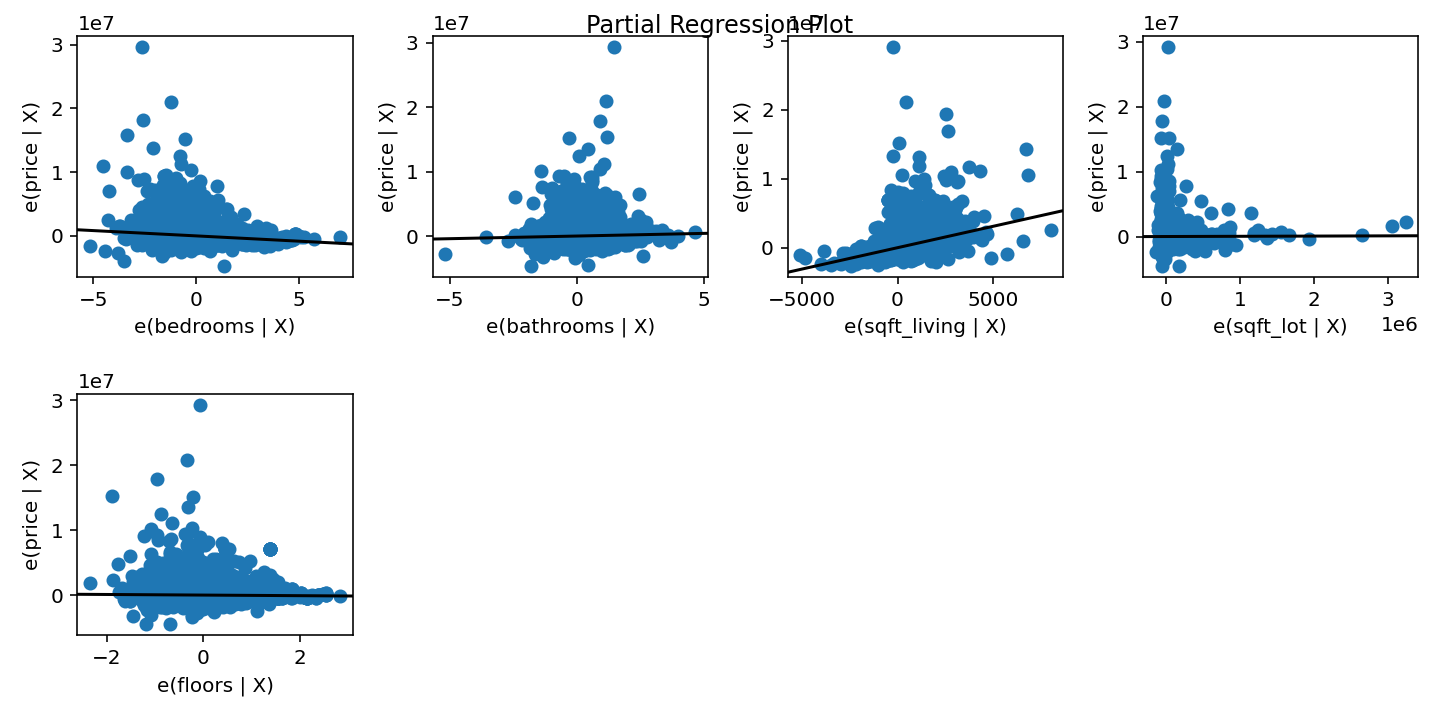

In [435]:
fig = plt.figure(figsize=(10,5))
sm.graphics.plot_partregress_grid(
    results_allnum,
    exog_idx=list(X_all.columns.values),
    grid=(2,4),
    fig=fig)
plt.show();

These models look worse, so likely we included too many features. Since the numeric features of bedrooms, sqft_lot, and floors do not appear to have a positive linear relationship with price, we will remove those features.

In [436]:
X_second = data1[['sqft_living', 'bathrooms']]
y = data1['price']

In [437]:

model_second = sm.OLS(y_log, sm.add_constant(X_second))
second_results = model_second.fit()

print(second_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     9625.
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        18:25:43   Log-Likelihood:                -19067.
No. Observations:               30155   AIC:                         3.814e+04
Df Residuals:                   30152   BIC:                         3.816e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.8989      0.007   1745.806      

Including bathrooms and sqft_living features improved the model (it only explains 2% more of the variance in price than sqft_living alone).

<IPython.core.display.Javascript object>


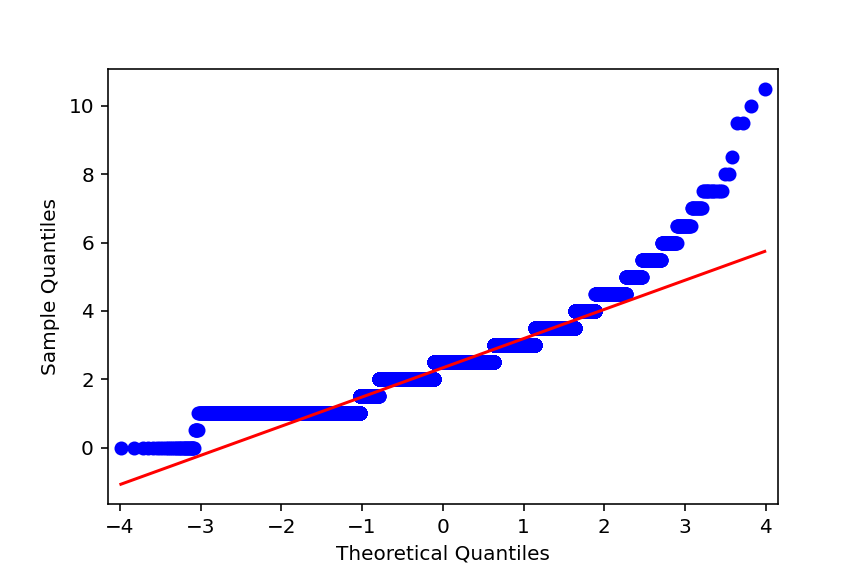

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


In [438]:
bathrooms_qq = sm.qqplot(data_pred['bathrooms'], line='r');

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<IPython.core.display.Javascript object>


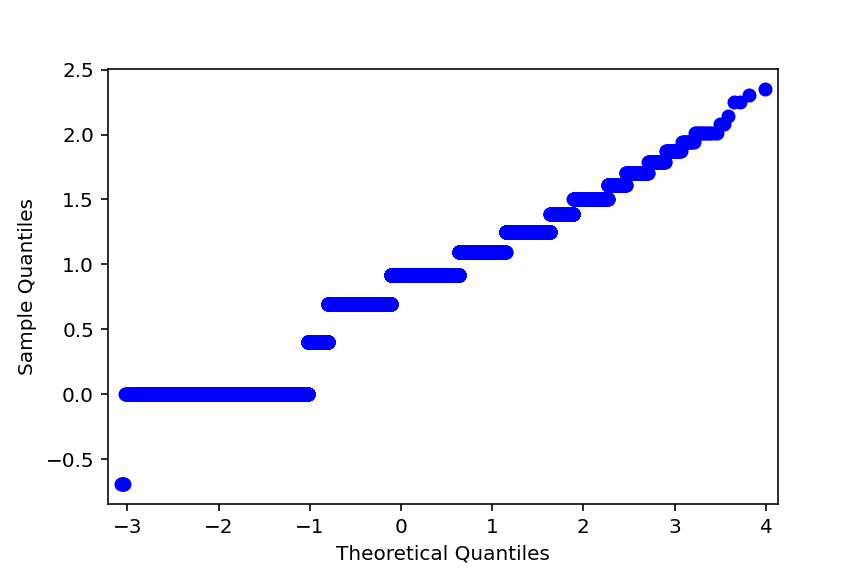

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


In [447]:
bathrooms_log_qq = sm.qqplot(np.log(data_pred['bathrooms']), line='r');

In [449]:
br_log = data_pred.copy()

br_log["log(bathrooms)"] = np.log(br_log["bathrooms"]+100)
br_log = br_log[["log(bathrooms)"]]


### ????????

In [450]:
br_log.describe()

,log(bathrooms)
count,30155.000000
mean,4.628212
std,0.008666
min,4.605170
25%,4.624973
50%,4.629863
75%,4.634729
max,4.705016


In [451]:
model_brlog = sm.OLS(y_log, sm.add_constant(br_log))
brlog_results = model_brlog.fit()

print(brlog_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                 1.097e+04
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        18:25:47   Log-Likelihood:                -21834.
No. Observations:               30155   AIC:                         4.367e+04
Df Residuals:                   30153   BIC:                         4.369e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -147.0329      1.535    -95.

#### Categorical model results:

In [452]:
waterfront_model = sm.OLS(y_log, sm.add_constant(waterfront_X))
wf_results = waterfront_model.fit()

print(wf_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     556.9
Date:                Mon, 29 May 2023   Prob (F-statistic):          5.00e-122
Time:                        18:25:48   Log-Likelihood:                -26235.
No. Observations:               30155   AIC:                         5.247e+04
Df Residuals:                   30153   BIC:                         5.249e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.7244      0.003   4090.

In [453]:
wf_results.params["waterfront_YES"] * 100

60.3538885928228

###### Interpretation:
Compared to a house that is not on a waterfront, for a house with a waterfront we see an associated increase of about 60.3% in price.

The model with waterfront explains about 1.8% of the variance in price and the F-statistic is statistically significant. 

In [454]:
greenbelt_model = sm.OLS(y_log, sm.add_constant(greenbelt_X))
gb_results = greenbelt_model.fit()

print(gb_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     289.2
Date:                Mon, 29 May 2023   Prob (F-statistic):           1.50e-64
Time:                        18:25:49   Log-Likelihood:                -26367.
No. Observations:               30155   AIC:                         5.274e+04
Df Residuals:                   30153   BIC:                         5.276e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.7256      0.003   4055.571

In [455]:
gb_results.params["greenbelt_YES"] * 100

35.946218831911295

###### Interpretation:
Compared to a house that is not near a greenbelt, for a house that is near a greenbelt we see an associated increase of about 35.9% in price.

The model with greenbelt explains about 0.9% of the variance in price and the F-statistic is statistically significant.

In [456]:
nuisance_model = sm.OLS(y_log, sm.add_constant(nuisance_X))
nu_results = nuisance_model.fit()

print(nu_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.648
Date:                Mon, 29 May 2023   Prob (F-statistic):              0.199
Time:                        18:25:51   Log-Likelihood:                -26510.
No. Observations:               30155   AIC:                         5.302e+04
Df Residuals:                   30153   BIC:                         5.304e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           13.7368      0.004   3718.290   

###### Interpretation:
The model with nuisance explains 0 percent of the variance in price and it is statistically significant. This may indicate that this model is not suited for linear regression.

In [457]:
view_model = sm.OLS(y_log, sm.add_constant(view_X))
vw_results = view_model.fit()

print(vw_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     644.0
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        18:25:52   Log-Likelihood:                -25275.
No. Observations:               30155   AIC:                         5.056e+04
Df Residuals:                   30150   BIC:                         5.060e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.9983      0.013   1094.

In [458]:
vw_results.params["view_EXCELLENT"] * 100

58.02950814025585

In [459]:
vw_results.params["view_GOOD"] * 100

16.325961239115617

In [460]:
vw_results.params["view_FAIR"] * 100

17.258201792170755

In [461]:
vw_results.params["view_NONE"] * 100

-31.768014004884904

###### Interpretation:
Compared to a house with an average view, we see an associated increase of about 58% in price for a house with an excellent view, an increase of about 16.3% in price for a house with a good view, an increase of about 17.3% for a house with a fair view, and a <b>decrease</b> of about 31.8% for a house with no view.

This model with view explains about 7.9% of the variance in price and it has an F-statistic of 0, so it is statistically significant.

Of the categorical variables, the ones that appear to be the best predictors of price are view and waterfront.

###### Interaction term results:

In [216]:

views_model = sm.OLS(y_log, sm.add_constant(views_X))
vws_results = views_model.fit()

print(vws_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     4101.
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        16:54:25   Log-Likelihood:                -18687.
No. Observations:               30155   AIC:                         3.739e+04
Df Residuals:                   30149   BIC:                         3.744e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.1118      0.012   1059.

In [241]:
interaction_model = sm.OLS(y, sm.add_constant(X_interaction))
interaction_results = interaction_model.fit()
print(interaction_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     3712.
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        17:03:57   Log-Likelihood:            -4.4776e+05
No. Observations:               30155   AIC:                         8.955e+05
Df Residuals:                   30148   BIC:                         8.956e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [242]:
interaction_model_ylog = sm.OLS(y_log, sm.add_constant(X_interaction))
interaction_results_ylog = interaction_model_ylog.fit()
print(interaction_results_ylog.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     3433.
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        17:03:58   Log-Likelihood:                -18661.
No. Observations:               30155   AIC:                         3.734e+04
Df Residuals:                   30148   BIC:                         3.739e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

This model explains about 42.5% of the error in price and is statistically significant, which is an improvement from our baseline model that only explained about 37% of the variance. 

In [243]:
pvalues_df = pd.DataFrame(interaction_results.pvalues, columns=["p-value"])
pvalues_df["p < 0.05"] = pvalues_df["p-value"] < 0.05
pvalues_df

,p-value,p < 0.05
const,5.605720e-28,True
sqft_living,0.000000e+00,True
view_EXCELLENT,8.314158e-01,False
view_FAIR,2.277006e-06,True
view_GOOD,4.336429e-04,True
view_NONE,7.465047e-33,True
sqft_living x Excellent view,8.580434e-107,True


In [244]:
interaction_results.params["const"]


207495.18076106964

??? For the reference category of having an average view and average square feet of living area, 
we expect to see a sale price of about 207,495 dollars.


In [246]:
interaction_results_ylog.params["const"] * 100

1309.8803337579602

??? For the reference category of having an average view and average square feet of living area, we see a sale price of aboutincrease of about 35.9% in price.

In [248]:
interaction_results.params["view_EXCELLENT"]* 100


1340775.3136123344

??? Having an excellent view, as opposed to having an average view, is associated with an increase of about 13,407 dollars in sale price with average square feet of living area.

In [250]:
interaction_results_ylog.params["view_EXCELLENT"]* 100


60.32879539423439

Having an excellent view, as opposed to having an average view, is associated with an increase of about 60.3% in sale price.

In [251]:
interaction_results.params["const"]* 100 + interaction_results.params["view_EXCELLENT"]* 100



22090293.3897193

??? For houses with an excellent view and average and average sqare feet of living area, we expect to see a price of about 220,902 dollars.

In [252]:
interaction_results_ylog.params["const"]* 100 + interaction_results_ylog.params["view_EXCELLENT"]* 100


1370.2091291521947

??? For houses with an excellent view and average sqare feet of living area, we expect to see a price of about 1370% .

#### MAE for interpretability of models:

###### MAE for baseline:

In [154]:
mae = baseline_results.resid.abs().sum() / len(y)
mae

396335.99168420106

In [155]:
mae = baseline_results_ylog.resid.abs().sum() / len(y)
mae

0.3353503298796063

Our baseline model, with the transformed y, is off by about ????

###### MAE for Interaction model:

In [95]:
mae = interaction_results.resid.abs().sum() / len(y)
mae

384550.34100360144

Our interaction model is off by about $384,550 in a given prediction. This is still high, but it is better than our baseline model.

In [253]:
mae = interaction_results_ylog.resid.abs().sum() / len(y)
mae

0.33052854375351776

###### Because the client intends to buy houses to flip them and resell for a higher price, it may be interesting to see how the condition of the house as well as the year it was renovated can affect the price, compared to the other features of the house.

In [467]:
data_compare = data_all[['price', 'condition', 'yr_renovated']].copy()
data_compare

,price,condition,yr_renovated
0,675000.0,Good,0
1,920000.0,Average,0
2,311000.0,Average,0
3,775000.0,Average,0
4,592500.0,Average,0
...,...,...,...
30150,1555000.0,Good,0
30151,1313000.0,Average,0
30152,800000.0,Average,0
30153,775000.0,Average,0


In [255]:
data_compare.head()

,price,condition,yr_renovated
0,675000.0,Good,0
1,920000.0,Average,0
2,311000.0,Average,0
3,775000.0,Average,0
4,592500.0,Average,0


In [256]:
data_compare['yr_renovated'].unique()

array([   0, 2005, 1995, 2008, 1978, 2015, 1992, 1990, 2004, 2019, 1998,
       2007, 1979, 2011, 2014, 1994, 1983, 1970, 1996, 2017, 1954, 2018,
       1989, 1982, 2006, 2002, 2013, 2003, 1988, 2000, 2016, 2021, 1971,
       1984, 1993, 2001, 1965, 1967, 1981, 1963, 1987, 1985, 1991, 1997,
       1955, 2012, 1986, 1999, 2010, 1956, 1962, 2020, 1969, 2009, 1950,
       1947, 1977, 1964, 1957, 1952, 1960, 1966, 1980, 2022, 1949, 1930,
       1959, 1974, 1928, 1961, 1946, 1968, 1975, 1973, 1958, 1976, 1945,
       1940, 1942, 1951, 1948, 1972, 1924])

In [257]:
data_compare['yr_renovated'].max()

2022

In [259]:
reno_X = data_compare[['yr_renovated']]


It looks like of the houses that have been renovated, the earliest renovation date was in 1924 and the latest was in 2022.

In [267]:
reno_model = sm.OLS(y, sm.add_constant(reno_X))
reno_results = reno_model.fit()
reno_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     218.3
Date:                Mon, 29 May 2023   Prob (F-statistic):           3.11e-49
Time:                        17:08:37   Log-Likelihood:            -4.5599e+05
No. Observations:               30155   AIC:                         9.120e+05
Df Residuals:                   30153   BIC:                         9.120e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.092e+06   5264.615    207.412      0.000    1.08e+06     1.1e+06
yr_renovated   182.4877     12.350     14.776      0.000     158.281     206.695
==============================================================================
Omnibus:                    37928.881   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14424827.299
Skew:                           6.591   Prob(JB):                         0.00
Kurtosis:                     109.333   Cond. No.                         436.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [289]:
pvalues_reno = pd.DataFrame(reno_results.pvalues, columns=["p-value"])
pvalues_reno["p < 0.05"] = pvalues_reno["p-value"] < 0.05
pvalues_reno

,p-value,p < 0.05
const,0.000000e+00,True
yr_renovated,3.110785e-49,True


In [270]:
reno_results.params["yr_renovated"] 

182.48769378915893

This model is statistically significant and it explains about 0.7% of the variance in price.
For each increase by one year in year renovated, a house is expected to increase in price by about $182.5. In housing prices, this is not a large increase.

In [269]:
reno_model_ylog = sm.OLS(y_log, sm.add_constant(reno_X))
reno_results_ylog = reno_model_ylog.fit()
reno_results_ylog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     175.5
Date:                Mon, 29 May 2023   Prob (F-statistic):           5.94e-40
Time:                        17:09:25   Log-Likelihood:                -26424.
No. Observations:               30155   AIC:                         5.285e+04
Df Residuals:                   30153   BIC:                         5.287e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           13.7251      0.003   4006.390      0.000      13.718      13.732
yr_renovated     0.0001   8.04e-06     13.249      0.000    9.07e-05       0.000
==============================================================================
Omnibus:                     1814.513   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7924.545
Skew:                           0.085   Prob(JB):                         0.00
Kurtosis:                       5.506   Cond. No.                         436.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [291]:
pvalues_reno_log = pd.DataFrame(reno_results_ylog.pvalues, columns=["p-value"])
pvalues_reno_log["p < 0.05"] = pvalues_reno_log["p-value"] < 0.05
pvalues_reno_log

,p-value,p < 0.05
const,0.000000e+00,True
yr_renovated,5.938505e-40,True


In [292]:
reno_results_ylog.params["yr_renovated"] * 100

0.010647450925796026

This model is statistically significant and it explains about 0.6% of the variance in price. For each increase by one year in year renovated, a house is expected to increase in price by about 0.01%.

In [274]:
data_compare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         30155 non-null  float64
 1   condition     30155 non-null  object 
 2   yr_renovated  30155 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 706.9+ KB


In [275]:
data_compare['condition'].unique()

array(['Good', 'Average', 'Very Good', 'Fair', 'Poor'], dtype=object)

In [276]:
data_compare1 = data_compare.copy()
data_compare1

,price,condition,yr_renovated
0,675000.0,Good,0
1,920000.0,Average,0
2,311000.0,Average,0
3,775000.0,Average,0
4,592500.0,Average,0
...,...,...,...
30150,1555000.0,Good,0
30151,1313000.0,Average,0
30152,800000.0,Average,0
30153,775000.0,Average,0


In [277]:
data_compare1.head()

,price,condition,yr_renovated
0,675000.0,Good,0
1,920000.0,Average,0
2,311000.0,Average,0
3,775000.0,Average,0
4,592500.0,Average,0


In [281]:
X_cond = data_compare[['condition']]
#X = data_num.drop("price", axis=1)
X_cond = pd.get_dummies(X_cond, columns=["condition"], drop_first=True)
X_cond

,condition_Fair,condition_Good,condition_Poor,condition_Very Good
0,0,1,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
30150,0,1,0,0
30151,0,0,0,0
30152,0,0,0,0
30153,0,0,0,0


In [282]:
cond_model = sm.OLS(y, sm.add_constant(X_cond))
cond_results = cond_model.fit()
cond_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     24.09
Date:                Mon, 29 May 2023   Prob (F-statistic):           6.34e-20
Time:                        17:12:48   Log-Likelihood:            -4.5605e+05
No. Observations:               30155   AIC:                         9.121e+05
Df Residuals:                   30150   BIC:                         9.121e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.134e+06   6571.947    172.603      0.000    1.12e+06    1.15e+06
condition_Fair      -3.544e+05   5.94e+04     -5.968      0.000   -4.71e+05   -2.38e+05
condition_Good      -8.109e+04   1.19e+04     -6.790      0.000   -1.05e+05   -5.77e+04
condition_Poor      -4.861e+05   1.11e+05     -4.371      0.000   -7.04e+05   -2.68e+05
condition_Very Good -3609.7218    1.7e+04     -0.212      0.832   -3.69e+04    2.97e+04
==============================================================================
Omnibus:                    37970.516   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14429452.738
Skew:                           6.606   Prob(JB):                         0.00
Kurtosis:                     109.347   Cond. No.                         22.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [290]:
pvalues_cond = pd.DataFrame(cond_results.pvalues, columns=["p-value"])
pvalues_cond["p < 0.05"] = pvalues_cond["p-value"] < 0.05
pvalues_cond

,p-value,p < 0.05
const,0.000000e+00,True
condition_Fair,2.423669e-09,True
condition_Good,1.144753e-11,True
condition_Poor,1.242707e-05,True
condition_Very Good,8.318425e-01,False


In [288]:
cond_results.params 

const                  1.134336e+06
condition_Fair        -3.544020e+05
condition_Good        -8.109344e+04
condition_Poor        -4.860529e+05
condition_Very Good   -3.609722e+03
dtype: float64

In [283]:
cond_model_ylog = sm.OLS(y_log, sm.add_constant(X_cond))
cond_results_ylog = cond_model_ylog.fit()
cond_results_ylog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     53.68
Date:                Mon, 29 May 2023   Prob (F-statistic):           3.72e-45
Time:                        17:12:50   Log-Likelihood:                -26404.
No. Observations:               30155   AIC:                         5.282e+04
Df Residuals:                   30150   BIC:                         5.286e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.7491      0.004   3223.584      0.000      13.741      13.757
condition_Fair         -0.3591      0.039     -9.319      0.000      -0.435      -0.284
condition_Good         -0.0476      0.008     -6.142      0.000      -0.063      -0.032
condition_Poor         -0.6665      0.072     -9.235      0.000      -0.808      -0.525
condition_Very Good     0.0238      0.011      2.154      0.031       0.002       0.045
==============================================================================
Omnibus:                     1819.128   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7718.780
Skew:                           0.117   Prob(JB):                         0.00
Kurtosis:                       5.467   Cond. No.                         22.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [293]:
pvalues_cond_log = pd.DataFrame(cond_results_ylog.pvalues, columns=["p-value"])
pvalues_cond_log["p < 0.05"] = pvalues_cond_log["p-value"] < 0.05
pvalues_cond_log

,p-value,p < 0.05
const,0.000000e+00,True
condition_Fair,1.250145e-20,True
condition_Good,8.258813e-10,True
condition_Poor,2.757599e-20,True
condition_Very Good,3.125244e-02,True


In [294]:
cond_results_ylog.params["condition_Very Good"] * 100

2.3763821578861792

In [295]:
cond_results_ylog.params["condition_Good"] * 100

-4.760776917749421

In [296]:
cond_results_ylog.params["condition_Fair"] * 100

-35.913789746915114

In [297]:
cond_results_ylog.params["condition_Poor"] * 100

-66.6489394908806

Compared to a house in average condition, we expect to see an increase in price of about 2.38% for a house in very good condition, a decrease of about 4.76% for a house in good condition, a decrease of about 35.91% for a house in fair condition, and a decrease of about 66.65% for a house in poor condition.

In [300]:
data_compare1 = pd.get_dummies(data_compare1, columns=["condition"], drop_first=True)


In [301]:
compare_X = data_compare1.copy()
compare_X = compare_X.drop("price", axis=1)

In [307]:
compare_model = sm.OLS(y_log, sm.add_constant(compare_X))
compare_results = compare_model.fit()
compare_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     76.93
Date:                Mon, 29 May 2023   Prob (F-statistic):           1.98e-80
Time:                        17:23:25   Log-Likelihood:                -26320.
No. Observations:               30155   AIC:                         5.265e+04
Df Residuals:                   30149   BIC:                         5.270e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.7366      0.004   3150.255      0.000      13.728      13.745
yr_renovated            0.0001   8.04e-06     12.990      0.000    8.87e-05       0.000
condition_Fair         -0.3538      0.038     -9.206      0.000      -0.429      -0.279
condition_Good         -0.0403      0.008     -5.194      0.000      -0.055      -0.025
condition_Poor         -0.6604      0.072     -9.175      0.000      -0.801      -0.519
condition_Very Good     0.0327      0.011      2.966      0.003       0.011       0.054
==============================================================================
Omnibus:                     1821.504   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7914.121
Skew:                           0.095   Prob(JB):                         0.00
Kurtosis:                       5.503   Cond. No.                     9.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model is statistically significant and explains about 1% of the variance in price.


In [308]:
pvalues_compare = pd.DataFrame(compare_results.pvalues, columns=["p-value"])
pvalues_compare["p < 0.05"] = pvalues_compare["p-value"] < 0.05
pvalues_compare

,p-value,p < 0.05
const,0.000000e+00,True
yr_renovated,1.758177e-38,True
condition_Fair,3.582873e-20,True
condition_Good,2.076333e-07,True
condition_Poor,4.786217e-20,True
condition_Very Good,3.023856e-03,True


In [309]:
compare_results.params * 100

const                  1373.664521
yr_renovated              0.010445
condition_Fair          -35.383142
condition_Good           -4.025338
condition_Poor          -66.038300
condition_Very Good       3.269089
dtype: float64

In [322]:
data_all2 = data_all[['view', 'sqft_living', 'yr_renovated', 'condition']]

In [323]:
data_all2 = pd.get_dummies(data_all2, columns=["condition", "view"], drop_first=True)
data_all2

,sqft_living,yr_renovated,condition_Fair,condition_Good,condition_Poor,condition_Very Good,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
0,1180,0,0,1,0,0,0,0,0,1
1,2770,0,0,0,0,0,0,0,0,0
2,2880,0,0,0,0,0,0,0,0,0
3,2160,0,0,0,0,0,0,0,0,0
4,1120,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
30150,1910,0,0,1,0,0,0,0,0,1
30151,2020,0,0,0,0,0,0,1,0,0
30152,1620,0,0,0,0,0,0,0,0,1
30153,2570,0,0,0,0,0,0,0,0,1


In [324]:
data_all2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   sqft_living          30155 non-null  int64
 1   yr_renovated         30155 non-null  int64
 2   condition_Fair       30155 non-null  uint8
 3   condition_Good       30155 non-null  uint8
 4   condition_Poor       30155 non-null  uint8
 5   condition_Very Good  30155 non-null  uint8
 6   view_EXCELLENT       30155 non-null  uint8
 7   view_FAIR            30155 non-null  uint8
 8   view_GOOD            30155 non-null  uint8
 9   view_NONE            30155 non-null  uint8
dtypes: int64(2), uint8(8)
memory usage: 706.9 KB


In [328]:
compare2_model = sm.OLS(y_log, sm.add_constant(data_all2))
compare2_results = compare2_model.fit()
compare2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     2087.
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        17:31:47   Log-Likelihood:                -18579.
No. Observations:               30155   AIC:                         3.718e+04
Df Residuals:                   30144   BIC:                         3.727e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.0945      0.013   1024.769      0.000      13.069      13.120
sqft_living             0.0004   2.75e-06    127.869      0.000       0.000       0.000
yr_renovated         5.612e-05   6.27e-06      8.956      0.000    4.38e-05    6.84e-05
condition_Fair         -0.1356      0.030     -4.547      0.000      -0.194      -0.077
condition_Good          0.0120      0.006      1.991      0.046       0.000       0.024
condition_Poor         -0.3685      0.056     -6.610      0.000      -0.478      -0.259
condition_Very Good     0.0738      0.009      8.637      0.000       0.057       0.091
view_EXCELLENT          0.3340      0.022     15.355      0.000       0.291       0.377
view_FAIR               0.1222      0.032      3.829      0.000       0.060       0.185
view_GOOD               0.0259      0.018      1.413      0.158      -0.010       0.062
view_NONE              -0.1423      0.011    -13.277      0.000      -0.163      -0.121
==============================================================================
Omnibus:                     6606.096   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54367.599
Skew:                          -0.827   Prob(JB):                         0.00
Kurtosis:                       9.367   Cond. No.                     5.03e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [594]:
data_all_ = data_all[['bathrooms', 'sqft_living', 'waterfront', 'view', 'yr_renovated', 'condition']].copy()

In [536]:
data_int2 = data_all_[['sqft_living', 'condition']]
data_int2 = pd.get_dummies(data_int2, columns = ['condition'], drop_first=True)

data_int2

,sqft_living,condition_Fair,condition_Good,condition_Poor,condition_Very Good
0,1180,0,1,0,0
1,2770,0,0,0,0
2,2880,0,0,0,0
3,2160,0,0,0,0
4,1120,0,0,0,0
...,...,...,...,...,...
30150,1910,0,1,0,0
30151,2020,0,0,0,0
30152,1620,0,0,0,0
30153,2570,0,0,0,0


In [559]:
data_int2["condition_Very Good x sqft_living"] = data_int2["sqft_living"] * data_int2["condition_Very Good"]
data_int2

,sqft_living,condition_Fair,condition_Good,condition_Poor,condition_Very Good,condition_Very Good x sqft_living
0,1180,0,1,0,0,0
1,2770,0,0,0,0,0
2,2880,0,0,0,0,0
3,2160,0,0,0,0,0
4,1120,0,0,0,0,0
...,...,...,...,...,...,...
30150,1910,0,1,0,0,0
30151,2020,0,0,0,0,0
30152,1620,0,0,0,0,0
30153,2570,0,0,0,0,0


In [560]:
interaction_model2 = sm.OLS(y, sm.add_constant(data_int2))
interaction_results2 = interaction_model2.fit()
print(interaction_results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     2971.
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        19:40:03   Log-Likelihood:            -4.4909e+05
No. Observations:               30155   AIC:                         8.982e+05
Df Residuals:                   30148   BIC:                         8.983e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [561]:
pvalues_compare = pd.DataFrame(interaction_results2.pvalues, columns=["p-value"])
pvalues_compare["p < 0.05"] = pvalues_compare["p-value"] < 0.05
pvalues_compare

,p-value,p < 0.05
const,3.051327e-12,True
sqft_living,0.000000e+00,True
condition_Fair,5.706339e-01,False
condition_Good,1.494066e-01,False
condition_Poor,9.532952e-01,False
condition_Very Good,4.368527e-02,True
condition_Very Good x sqft_living,1.058347e-06,True


In [562]:
interaction_results2.params 

const                               -76540.916145
sqft_living                            555.019565
condition_Fair                       26795.221170
condition_Good                       13715.519720
condition_Poor                        5176.901615
condition_Very Good                 -67560.919853
condition_Very Good x sqft_living       73.245584
dtype: float64

In [564]:
interaction_results2.params["condition_Very Good x sqft_living"] + interaction_results2.params["sqft_living"]

628.2651491083724

**For houses in very good condition, there is an associated increase of about $628.26 in price for each additional square foot of living area.**

In [558]:
interaction_results2.params["const"] + interaction_results2.params["condition_Very Good"]

-8386.512897616805

For houses of average square footage of living area and in average condition, we expect to see a sale price of about 

***for vehicles with 4 cylinders, there is an additional decrease of about 0.005 in miles per gallon for each additional pound of vehicle weight, above and beyond the decrease represented by $\beta_1$***.
For houses in very good condition, there is an additional increase of about 0.00005% for each additional square foot of living space...

In [519]:
interaction_results2.params["condition_Very Good"]*100

220.47627755482515

??? For a house in very good condition, as opposed to average, we expect to see a price increase of about 220.5%.

In [579]:
data_all2 = data_all_.copy()
data_all2["sqft_living"] = data_all2["sqft_living"] - data_all2["sqft_living"].mean()
data_all2["yr_renovated"] = (data_all2["yr_renovated"] - 1924)

In [585]:
data_int3 = data_all2[['view', 'yr_renovated']]
data_int3 = pd.get_dummies(data_int3, columns = ['view'], drop_first=True)

In [586]:
data_int3["yr_renovated x view_EXCELLENT"] = data_int3["yr_renovated"] * data_int3["view_EXCELLENT"]
data_int3

,yr_renovated,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,yr_renovated x view_EXCELLENT
0,-1924,0,0,0,1,0
1,-1924,0,0,0,0,0
2,-1924,0,0,0,0,0
3,-1924,0,0,0,0,0
4,-1924,0,0,0,1,0
...,...,...,...,...,...,...
30150,-1924,0,0,0,1,0
30151,-1924,0,1,0,0,0
30152,-1924,0,0,0,1,0
30153,-1924,0,0,0,1,0


In [587]:
interaction_model3 = sm.OLS(y, sm.add_constant(data_int3))
interaction_results3 = interaction_model3.fit()
print(interaction_results3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     683.8
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        19:59:16   Log-Likelihood:            -4.5417e+05
No. Observations:               30155   AIC:                         9.084e+05
Df Residuals:                   30148   BIC:                         9.084e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [588]:
pvalues_compare = pd.DataFrame(interaction_results3.pvalues, columns=["p-value"])
pvalues_compare["p < 0.05"] = pvalues_compare["p-value"] < 0.05
pvalues_compare

,p-value,p < 0.05
const,0.000000e+00,True
yr_renovated,2.195261e-13,True
view_EXCELLENT,4.640101e-95,True
view_FAIR,2.312309e-06,True
view_GOOD,2.286654e-16,True
view_NONE,2.228297e-100,True
yr_renovated x view_EXCELLENT,2.683662e-04,True


In [589]:
interaction_results3.params

const                            1.608114e+06
yr_renovated                     8.873935e+01
view_EXCELLENT                   1.803036e+06
view_FAIR                        2.829360e+05
view_GOOD                        2.814777e+05
view_NONE                       -4.254590e+05
yr_renovated x view_EXCELLENT    1.767623e+02
dtype: float64

For a house with an average view that was renovated in 1924, we expect to see a sale price of about $1,609,114.

For houses with an excellent view, as opposed to an average view, we expect to see an increase in price of about $1,803,038 for each more recent renovation year.

In [590]:
interaction_results3.params["const"] + interaction_results3.params["view_EXCELLENT"]

3411149.925412275

For a house with a renovation year of 1924 and an excellent view, we expect to see a sale price of about $3,411,150.

In [591]:
interaction_results3.params["yr_renovated x view_EXCELLENT"] + interaction_results3.params["yr_renovated"]

265.5016622490363

For houses with an excellent view, there is an associated increase of about $265.50 in sale price for each year more recently that it was renovated.

In [580]:
data_int4 = data_all2[['sqft_living', 'yr_renovated']].copy()

In [581]:
data_int4["yr_renovated x sqft_living"] = data_int4["yr_renovated"] * data_int4["sqft_living"]
data_int4

,sqft_living,yr_renovated,yr_renovated x sqft_living
0,-932.424739,-1924,1.793985e+06
1,657.575261,-1924,-1.265175e+06
2,767.575261,-1924,-1.476815e+06
3,47.575261,-1924,-9.153480e+04
4,-992.424739,-1924,1.909425e+06
...,...,...,...
30150,-202.424739,-1924,3.894652e+05
30151,-92.424739,-1924,1.778252e+05
30152,-492.424739,-1924,9.474252e+05
30153,457.575261,-1924,-8.803748e+05


In [582]:
interaction_model4 = sm.OLS(y, sm.add_constant(data_int4))
interaction_results4 = interaction_model4.fit()
print(interaction_results4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     6127.
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        19:53:20   Log-Likelihood:            -4.4892e+05
No. Observations:               30155   AIC:                         8.978e+05
Df Residuals:                   30151   BIC:                         8.979e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [600]:
pvalues_compare = pd.DataFrame(interaction_results4.pvalues, columns=["p-value"])
pvalues_compare["p < 0.05"] = pvalues_compare["p-value"] < 0.05
pvalues_compare

,p-value,p < 0.05
const,0.000000e+00,True
sqft_living,0.000000e+00,True
yr_renovated,4.180624e-28,True
yr_renovated x sqft_living,3.399215e-51,True


In [584]:
interaction_results4.params

const                         1.305959e+06
sqft_living                   8.181007e+02
yr_renovated                  1.089178e+02
yr_renovated x sqft_living    1.428918e-01
dtype: float64

For a house renovated in 1924 with an average square footage of living area, we expect to see a price of about $1,305,959.

For a house renovated in 1924, there is an increase of about $818 for each addition square foot of living area.

For a house of average square footage of living area, there is an increase of about $109 for each year more recently it was renovated. 

In [595]:
data_int5 = data_all_[['bathrooms', 'condition']].copy()
data_int5 = pd.get_dummies(data_int5, columns = ['condition'], drop_first=True)

In [598]:
data_int5["bathooms x condition_Very Good"] = data_int5["bathrooms"] * data_int5["condition_Very Good"]
data_int5

,bathrooms,condition_Fair,condition_Good,condition_Poor,condition_Very Good,bathooms x condition_Very Good
0,1.0,0,1,0,0,0.0
1,2.5,0,0,0,0,0.0
2,2.0,0,0,0,0,0.0
3,3.0,0,0,0,0,0.0
4,2.0,0,0,0,0,0.0
...,...,...,...,...,...,...
30150,2.0,0,1,0,0,0.0
30151,2.0,0,0,0,0,0.0
30152,2.0,0,0,0,0,0.0
30153,2.5,0,0,0,0,0.0


In [612]:
interaction_model5 = sm.OLS(y, sm.add_constant(data_int5))
interaction_results5 = interaction_model5.fit()
print(interaction_results5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     1513.
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        20:23:16   Log-Likelihood:            -4.5213e+05
No. Observations:               30155   AIC:                         9.043e+05
Df Residuals:                   30148   BIC:                         9.043e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [613]:
pvalues_compare = pd.DataFrame(interaction_results5.pvalues, columns=["p-value"])
pvalues_compare["p < 0.05"] = pvalues_compare["p-value"] < 0.05
pvalues_compare

,p-value,p < 0.05
const,0.004227,True
bathrooms,0.000000,True
condition_Fair,0.118373,False
condition_Good,0.000437,True
condition_Poor,0.797101,False
condition_Very Good,0.882952,False
bathooms x condition_Very Good,0.186161,False


In [614]:
interaction_results5.params

const                             -40928.667272
bathrooms                         484989.915449
condition_Fair                     81779.956990
condition_Good                     37177.195597
condition_Poor                     25148.444581
condition_Very Good                 6434.811892
bathooms x condition_Very Good     23574.651269
dtype: float64

## Conclusion

- (DONE but need help to interpret) Next steps: QQ Plot for variables OTHER than target
- What goes in results vs model section? 
- (DONE) add variables together/interaction variables?? 
- Add condition+year renovated vars to sqft_living and view to see potential of profit
- (DONE) show that including sqft_above could cause multicollineairty and therefore I didnt use it

The most important things to look for in a house to buy to flip are the square feet of living area the house has, houses with an above average view and/or are on a waterfront, and the number of bathrooms a house has.